In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization as well
import os
import warnings
from tqdm.notebook import tqdm # for progress bar
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img # we import the function used to import images in PIL format
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2024-02-17 12:11:45.298968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 12:11:45.299061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 12:11:45.465342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace' #we will use this variable to refer to the dataset

In [3]:
#labels: age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    #we use the underscore to split because our filenames are all of the type:
    #100_0_0_... where the first value is the age, the second one is the gender, represented as a boolean (0 for man, 1 for woman), the third one is the ethnicity, etc
    age = int(temp[0])
    gender = int(temp[1])
    #we now fill the lists we created before:
    #this will be our input
    image_paths.append(image_path)
    
    #this will be our otput
    age_labels.append(age)
    gender_labels.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
#now that we properly loaded the dataset, we convert it into a dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels #we create the columns
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [5]:
#we create a dictionary for genders
gender_dict = {0: 'Male', 1:'Female'}

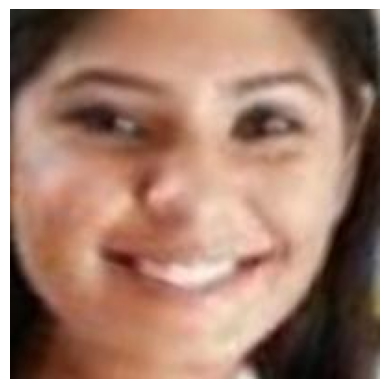

In [6]:
#we are going to display just 1 image
from PIL import Image
img = Image.open(df['image'][2])
plt.axis('off') #we get rid of the x and y axis, we don't need them
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

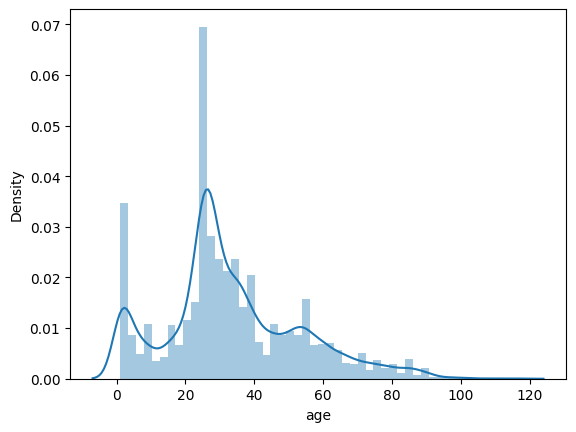

In [7]:
sns.distplot(df['age']) #we use seaborn to visualize the distribution of the age

<Axes: ylabel='count'>

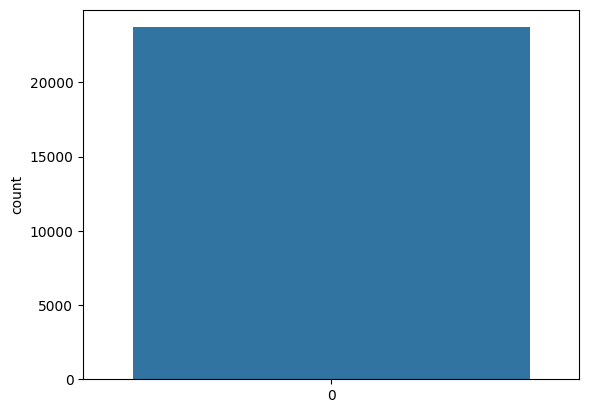

In [8]:
sns.countplot(df['gender']) #we use seaborn to visualize how many men and women are there in the dataset

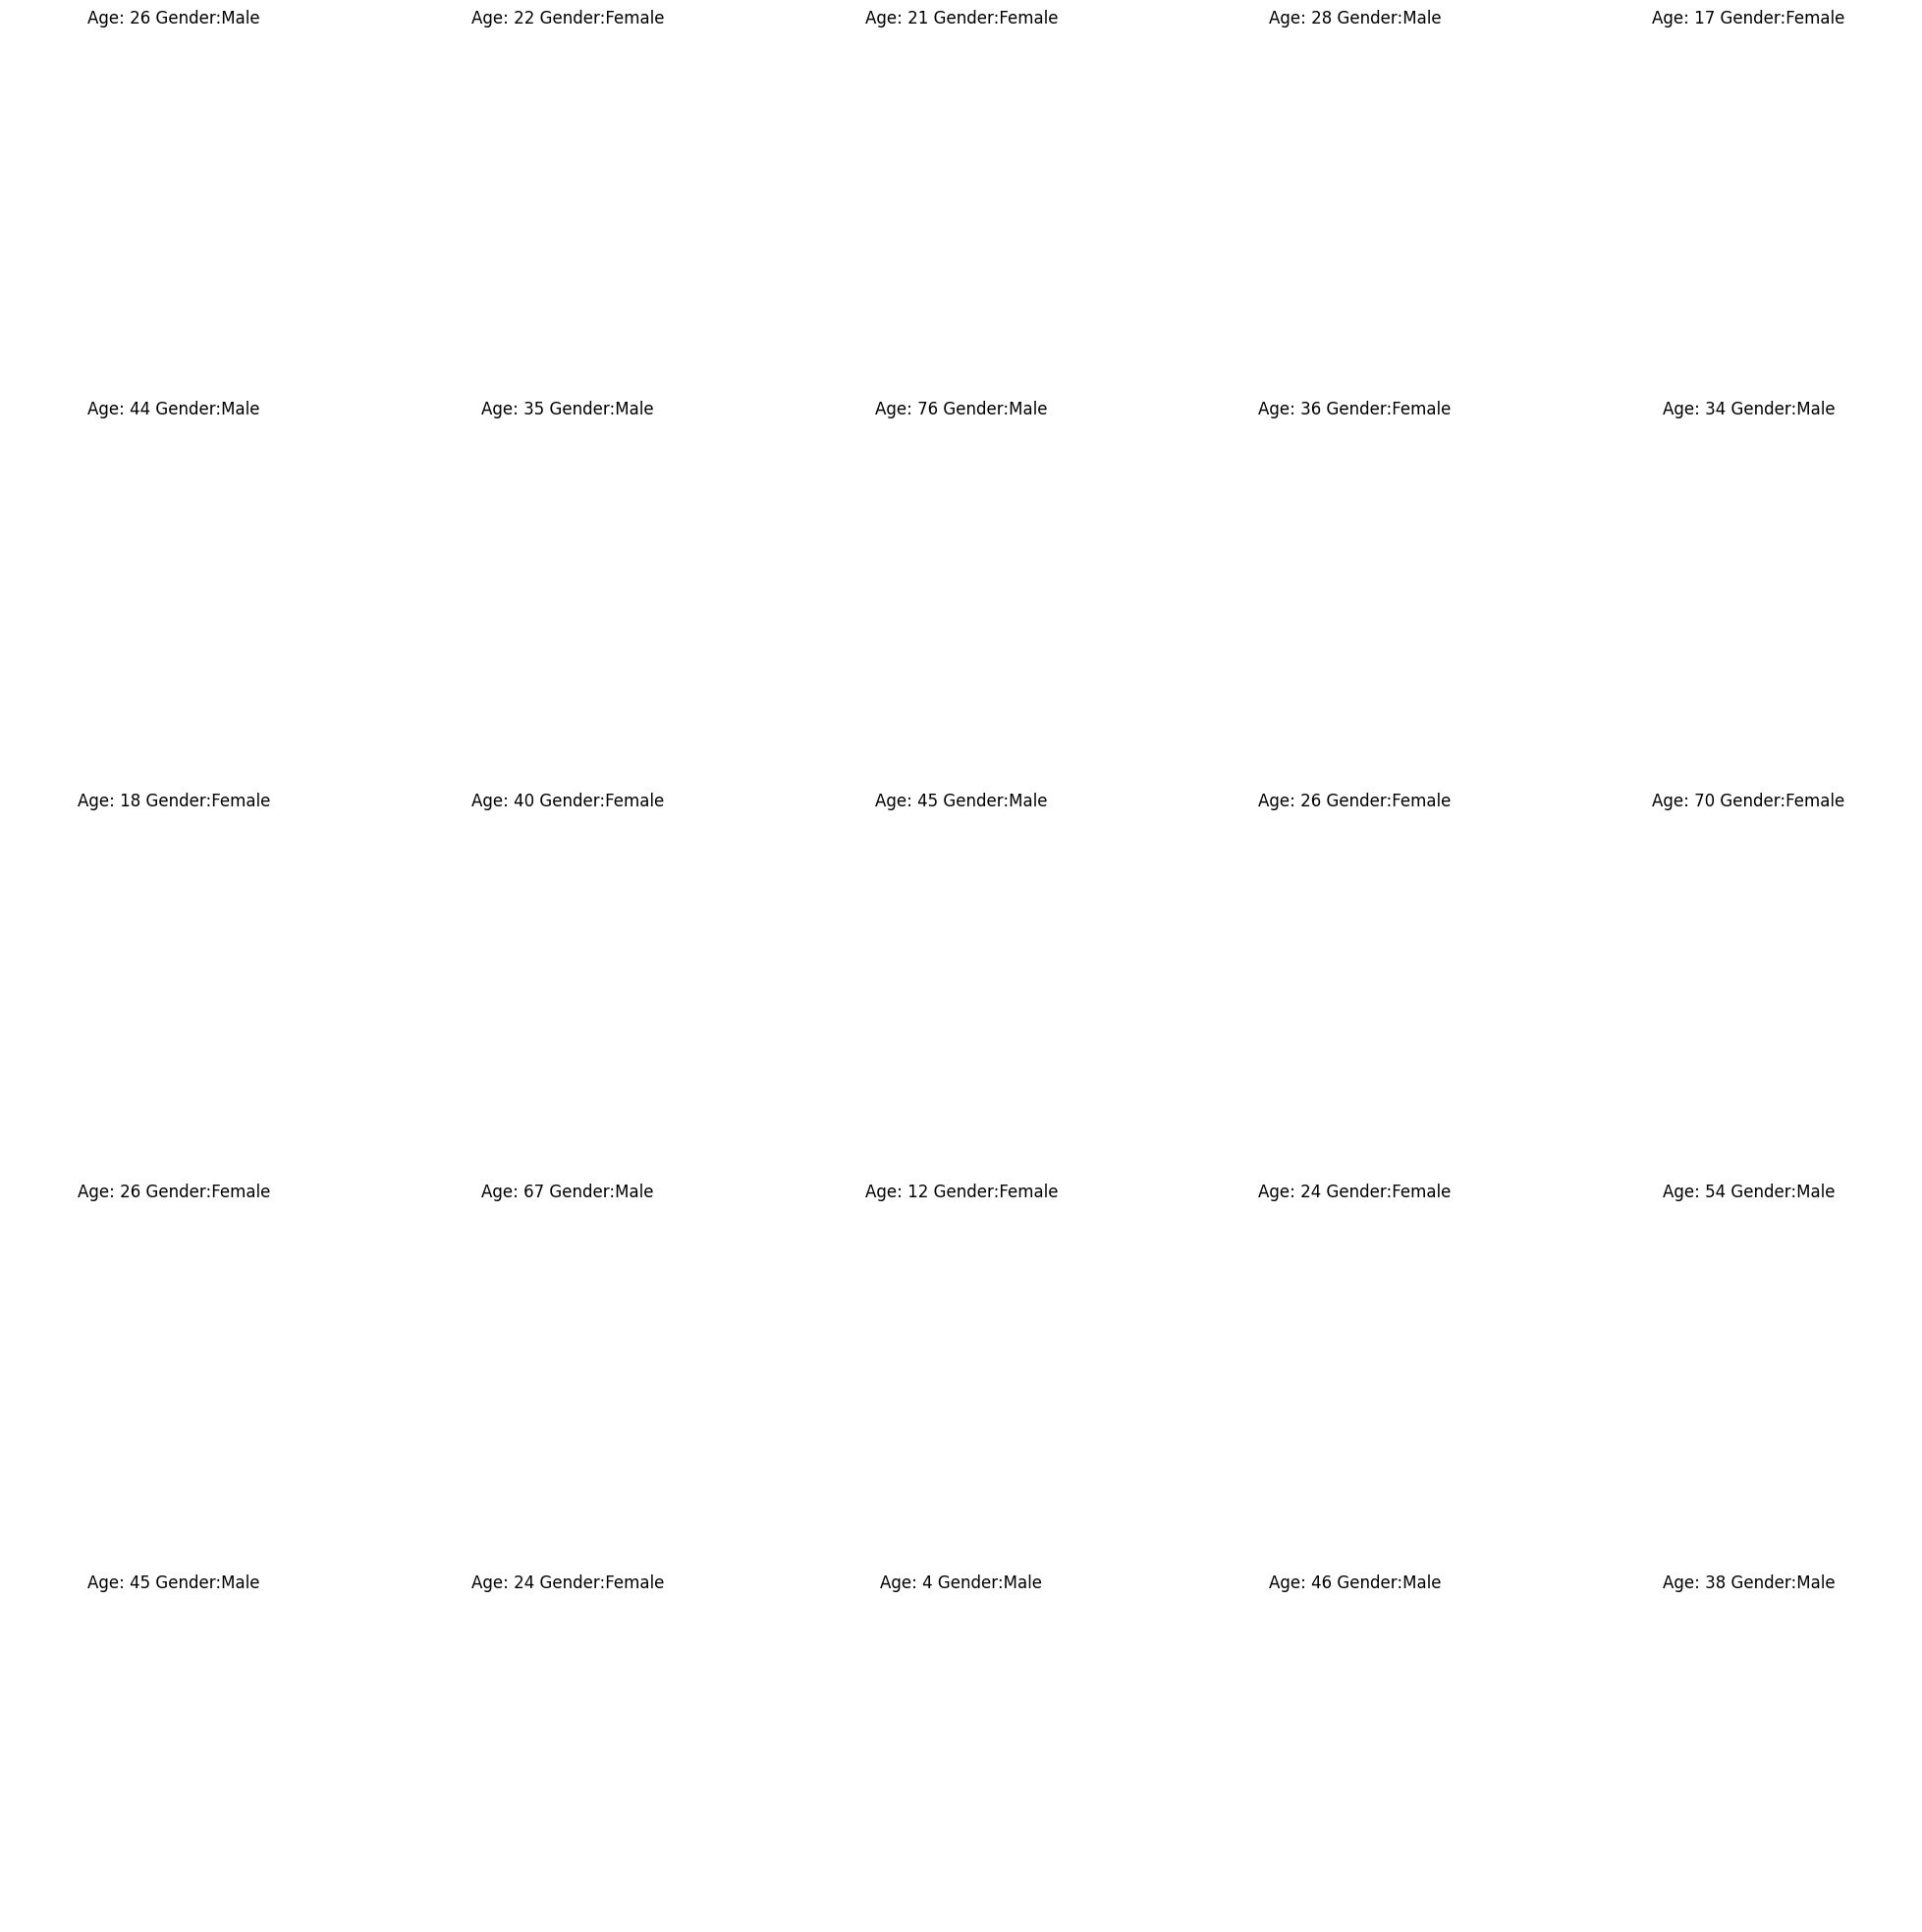

In [9]:
# we display a grid of images
plt.figure(figsize=(25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.title(f"Age: {age} Gender:{gender_dict[gender]}")
    plt.axis('off')


In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # we use greyscale, so there are not 3 values (rbg), that's why we use 1 as a value
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
X.shape

(23708, 128, 128, 1)

In [13]:
#normalizing the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128,128,1) #again 1 instead of 3 because of grey scale
#images are the input, and we are going to get one output for classification, another one for regression
inputs = Input((input_shape))

#convolutional layers

conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs) #relu improves the performance
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1) #relu improves the performance
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2) #relu improves the performance
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3) #relu improves the performance
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

#flattening (from 2D to 1D array)
flatten = Flatten() (maxp_4)

#fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

#binary_crossentropy is for binary classifications (we use it for the gender)
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

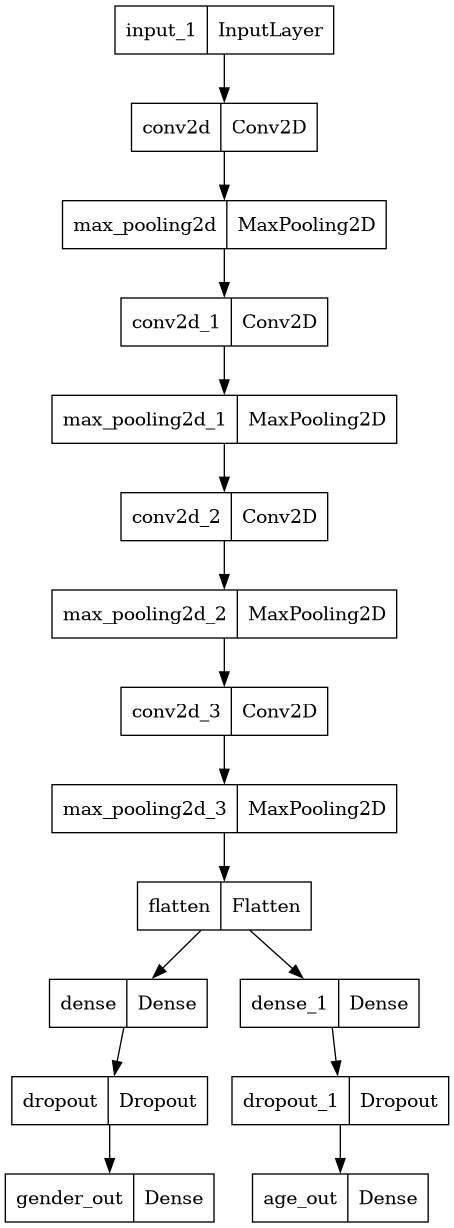

In [17]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [18]:
#train the model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30


I0000 00:00:1708172082.183003      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 [==============================] - 21s 22ms/step - loss: 15.9110 - gender_out_loss: 0.6833 - age_out_loss: 15.2277 - gender_out_accuracy: 0.5420 - age_out_accuracy: 0.0477 - val_loss: 12.8945 - val_gender_out_loss: 0.5528 - val_age_out_loss: 12.3417 - val_gender_out_accuracy: 0.7176 - val_age_out_accuracy: 0.0462
Epoch 2/30
593/593 [==============================] - 11s 19ms/step - loss: 11.9517 - gender_out_loss: 0.5124 - age_out_loss: 11.4393 - gender_out_accuracy: 0.7507 - age_out_accuracy: 0.0347 - val_loss: 10.1887 - val_gender_out_loss: 0.4529 - val_age_out_loss: 9.7358 - val_gender_out_accuracy: 0.7809 - val_age_out_accuracy: 0.0236
Epoch 3/30
593/593 [==============================] - 11s 19ms/step - loss: 10.1735 - gender_out_loss: 0.4393 - age_out_loss: 9.7342 - gender_out_accuracy: 0.7898 - age_out_accuracy: 0.0166 - val_loss: 9.7065 - val_gender_out_loss: 0.3954 - val_age_out_loss: 9.3111 - val_gender_out_accuracy: 0.8176 - val_age_out_accuracy: 0.0074
Epoch 4/30
59

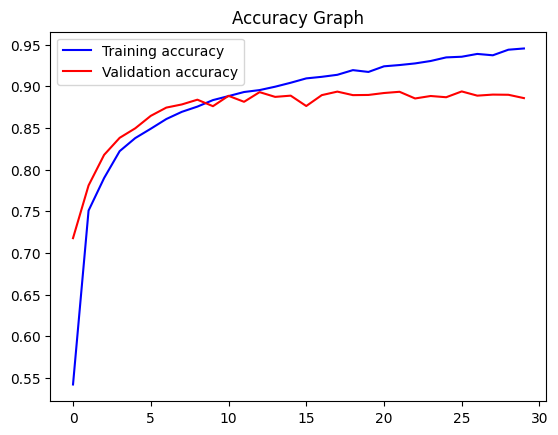

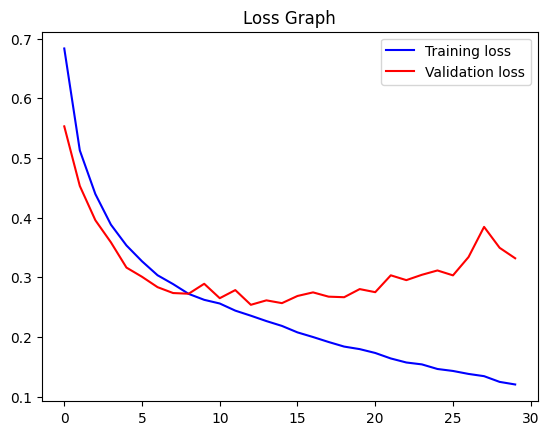

In [19]:
#plotting results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

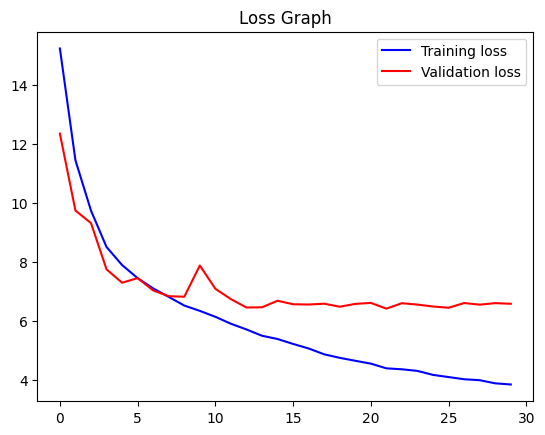

In [20]:
#plotting results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Example of really accurate predicition:

Original Gender:  Male Original Age:  28
1/1 [==============================] - 0s 424ms/step
Predicted Gender:  Male Predicted Age:  23


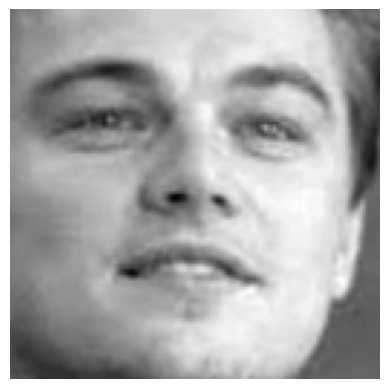

In [21]:
#we try and pick an image from the dataset, to test the algorithm
image_index = 3
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#we predict with the model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');

## Example of not so accurate prediction:

Original Gender:  Male Original Age:  26
1/1 [==============================] - 0s 20ms/step
Predicted Gender:  Male Predicted Age:  22


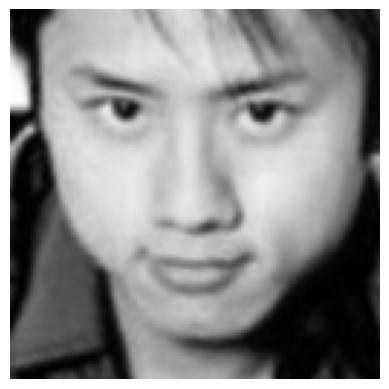

In [22]:
#we try and pick an image from the dataset, to test the algorithm
image_index = 0
print("Original Gender: ", gender_dict[y_gender[image_index]], "Original Age: ", y_age[image_index])
#we predict with the model
pred = model.predict(X[image_index].reshape(1,128,128,1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender: ", pred_gender, "Predicted Age: ",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128), cmap='gray');